In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import pandas as pd
import joblib
import sys

# Add the project root to the path so we can import the img2vec module
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
    print("Added project root to path.")
else:
    print("Project root is already in the path.")
from img2vec import pretrain_pca,rgb2flatPCA

# Define the batch size
batch_size = 64

# PCA components - this will be the dimension of our feature vectors
n_components = 100

Added project root to path.


### read the data

In [2]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### Encode age labels

In [3]:
if os.path.exists('age_encoder.pkl'):
    age_encoder = joblib.load('age_encoder.pkl')
    print("Age encoder loaded successfully.")
    
    # Use transform only when encoder is loaded
    train_data['age_label'] = age_encoder.transform(train_data['age'])
    val_data['age_label'] = age_encoder.transform(val_data['age'])
    test_data['age_label'] = age_encoder.transform(test_data['age'])
else:
    age_encoder = LabelEncoder()
    
    # Fit and transform on training data
    train_data['age_label'] = age_encoder.fit_transform(train_data['age'])
    
    # Then just transform validation and test data
    val_data['age_label'] = age_encoder.transform(val_data['age'])
    test_data['age_label'] = age_encoder.transform(test_data['age'])
    
    # Save after fitting
    joblib.dump(age_encoder, 'age_encoder.pkl')
    print("Age encoder saved successfully.")

num_classes = len(age_encoder.classes_)
print("Age classes:", age_encoder.classes_)

Age encoder loaded successfully.
Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']


### add the path of the images

In [4]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])


train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)
train_data.head(5)

,user_id,face_id,original_image,age,gender,age_label,img_path
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,6,..\..\data\faces\9855553@N08\coarse_tilt_align...
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,1,..\..\data\faces\114841417@N06\coarse_tilt_ali...
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,2,..\..\data\faces\66870968@N06\coarse_tilt_alig...
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,0,..\..\data\faces\8187011@N06\coarse_tilt_align...
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,1,..\..\data\faces\114841417@N06\coarse_tilt_ali...


#### add column for check if the image exists
it will help us to detect if there is any missing image, or if there is any bug in the path construction

In [5]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

train_data.head(5)

,user_id,face_id,original_image,age,gender,age_label,img_path,img_exists
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,6,..\..\data\faces\9855553@N08\coarse_tilt_align...,True
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,1,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,2,..\..\data\faces\66870968@N06\coarse_tilt_alig...,True
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,0,..\..\data\faces\8187011@N06\coarse_tilt_align...,True
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,1,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True


### Filter out any rows where the image doesn't exist

In [6]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

### Extract image paths and labels

In [7]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['age_label'].values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['age_label'].values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['age_label'].values

### Define function that processes features in batches and stores them to avoid recomputation

In [8]:

def preprocess_and_save_features_pca(image_paths, output_file, n_components=256, batch_size=64):
    """
    Process images using PCA and save features to avoid recomputation.
    
    Args:
        image_paths: List of image paths to process
        output_file: File to save/load processed features
        n_components: Number of PCA components to use
        batch_size: Batch size for processing
        
    Returns:
        numpy.ndarray: PCA-reduced features
    """
    if os.path.exists(output_file):
        print(f"Loading pre-processed PCA features from {output_file}")
        return np.load(output_file)
    
    print(f"Processing {len(image_paths)} images with PCA and saving to {output_file}")
    all_features = []
    
    # Process images in batches to avoid memory issues
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{math.ceil(len(image_paths)/batch_size)}")
        
        # Use rgb2flatPCA instead of rgb2emb
        batch_features = rgb2flatPCA(batch_paths, n_components=n_components)
        all_features.append(batch_features)
    
    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Use a subset of training images to pre-train PCA

In [9]:
print("Pre-training PCA with a subset of training images...")
print("the number of training images is", len(train_image_paths))
n_pretrain = len(train_image_paths)  # Use fewer images
pretrain_pca(train_image_paths, n_components=n_components)
print("PCA pre-training completed.")

Pre-training PCA with a subset of training images...
the number of training images is 11856
Pre-training Incremental PCA with 11856 images...
Reducing n_components from 256 to 100 to match batch size.
Processing batch 1/119...
Processing batch 2/119...
Processing batch 3/119...
Processing batch 4/119...
Processing batch 5/119...
Processing batch 6/119...
Processing batch 7/119...
Processing batch 8/119...
Processing batch 9/119...
Processing batch 10/119...
Processing batch 11/119...
Processing batch 12/119...
Processing batch 13/119...
Processing batch 14/119...
Processing batch 15/119...
Processing batch 16/119...
Processing batch 17/119...
Processing batch 18/119...
Processing batch 19/119...
Processing batch 20/119...
Processing batch 21/119...
Processing batch 22/119...
Processing batch 23/119...
Processing batch 24/119...
Processing batch 25/119...
Processing batch 26/119...
Processing batch 27/119...
Processing batch 28/119...
Processing batch 29/119...
Processing batch 30/119..

### Process and save features

In [10]:
print("Extracting PCA features from images...")
train_features_file = f'train_features_pca_{n_components}.npy'
val_features_file = f'val_features_pca_{n_components}.npy'
test_features_file = f'test_features_pca_{n_components}.npy'

train_features = preprocess_and_save_features_pca(train_image_paths, train_features_file, n_components)
val_features = preprocess_and_save_features_pca(val_image_paths, val_features_file, n_components)
test_features = preprocess_and_save_features_pca(test_image_paths, test_features_file, n_components)

print("Feature extraction completed.")
print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


Extracting PCA features from images...
Processing 11856 images with PCA and saving to train_features_pca_256.npy
Processing batch 1/186
Will use a partial transformation and pad with zeros.
Processing batch 2/186
Will use a partial transformation and pad with zeros.
Processing batch 3/186
Will use a partial transformation and pad with zeros.
Processing batch 4/186
Will use a partial transformation and pad with zeros.
Processing batch 5/186
Will use a partial transformation and pad with zeros.
Processing batch 6/186
Will use a partial transformation and pad with zeros.
Processing batch 7/186
Will use a partial transformation and pad with zeros.
Processing batch 8/186
Will use a partial transformation and pad with zeros.
Processing batch 9/186
Will use a partial transformation and pad with zeros.
Processing batch 10/186
Will use a partial transformation and pad with zeros.
Processing batch 11/186
Will use a partial transformation and pad with zeros.
Processing batch 12/186
Will use a par

### Standardize features

In [11]:
scaler_file = f'feature_scaler_pca_{n_components}.pkl'

if os.path.exists(scaler_file):
    scaler = joblib.load(scaler_file)
    print("Feature scaler loaded successfully.")
    
    train_features_scaled = scaler.transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(test_features)
else:
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(test_features)

    # Save the scaler
    joblib.dump(scaler, scaler_file)
    print("Feature scaler created and saved successfully.")

Feature scaler created and saved successfully.


### Define the model

In [12]:
model = Sequential([
    Dense(num_classes, activation='softmax', input_shape=(n_components,),
          kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\dell\OneDrive - Ariel University\Desktop\some_real_code\VisAge\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,056 (8.03 KB)

 Trainable params: 2,056 (8.03 KB)

 Non-trainable params: 0 (0.00 B)

### train the model

In [13]:
print("Training the model...")
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_features_scaled, train_labels,
    validation_data=(val_features_scaled, val_labels),
    epochs=30,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Training the model...
Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1324 - loss: 2.2405 - val_accuracy: 0.1296 - val_loss: 2.1342
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1338 - loss: 2.1176 - val_accuracy: 0.1316 - val_loss: 2.0886
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1506 - loss: 2.0640 - val_accuracy: 0.1397 - val_loss: 2.0744
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1618 - loss: 2.0450 - val_accuracy: 0.1447 - val_loss: 2.0717
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1696 - loss: 2.0280 - val_accuracy: 0.1420 - val_loss: 2.0724
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1638 - loss: 2.0635 - val_accuracy: 0.1417 - val_loss: 2.0734
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1685 - loss: 2.0229 - val_accuracy: 0.1407 - val_loss: 2.0740
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1736 - loss: 2.0

### Save the model

In [14]:
model_file = f'softmax_age_classifier_pca_{n_components}.h5'
model.save(model_file)
print(f"Model saved to {model_file}")

Model saved to softmax_age_classifier_pca_256.h5


### Evaluate the model on test data

In [15]:
print("Evaluating the model on test data...")
test_loss, test_acc = model.evaluate(test_features_scaled, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating the model on test data...
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1275 - loss: 2.0878
Test Loss: 2.0871
Test Accuracy: 0.1214


### Get predictions

In [16]:
test_predictions = model.predict(test_features_scaled)
test_pred_classes = np.argmax(test_predictions, axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Visualize results

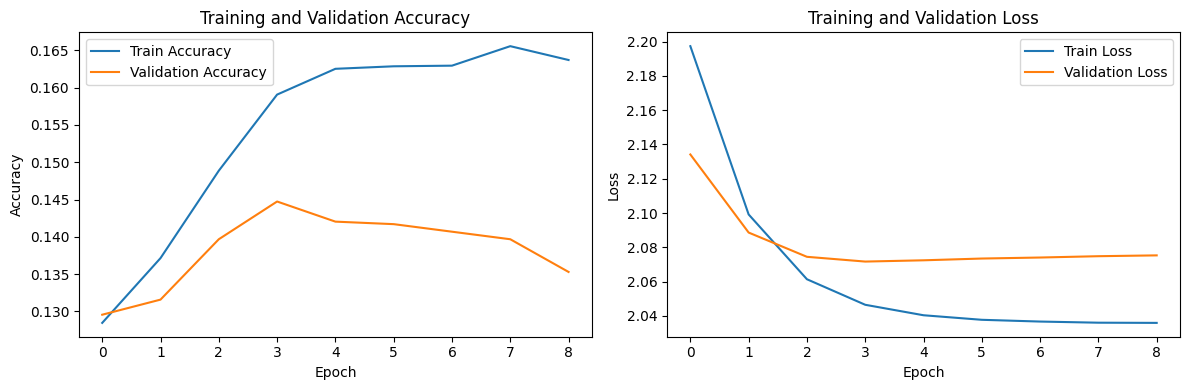

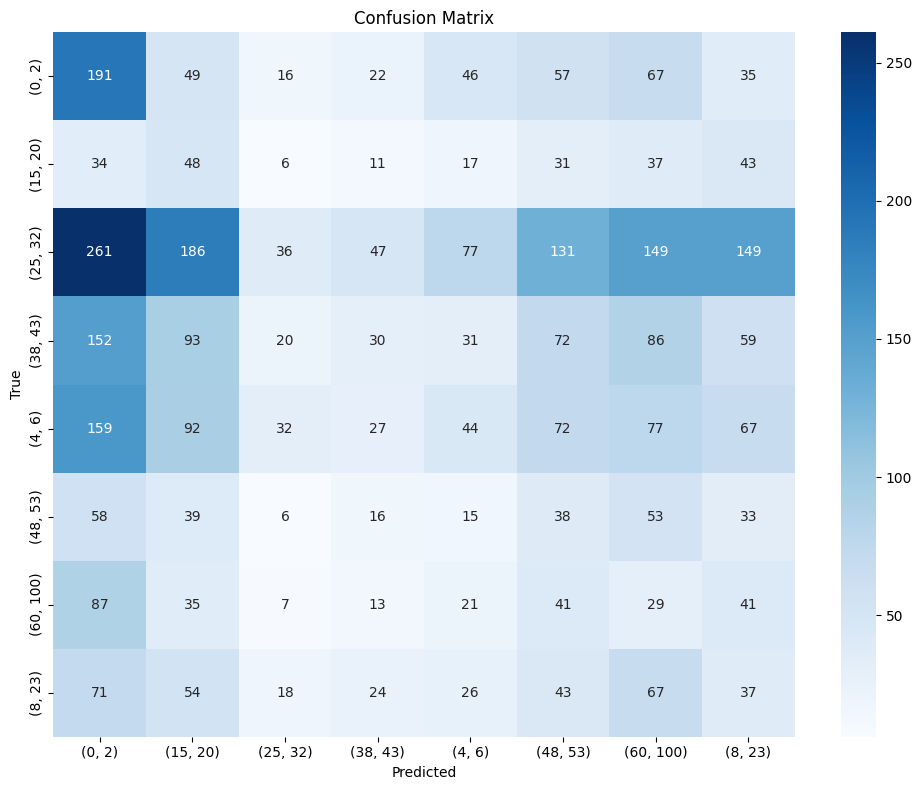

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig(f'training_history_pca_{n_components}.png')
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=age_encoder.classes_,
            yticklabels=age_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(f'confusion_matrix_pca_{n_components}.png')
plt.show()


### Classification report

In [18]:
print("Classification Report:")
print(classification_report(test_labels, test_pred_classes, target_names=age_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.19      0.40      0.26       483
    (15, 20)       0.08      0.21      0.12       227
    (25, 32)       0.26      0.03      0.06      1036
    (38, 43)       0.16      0.06      0.08       543
      (4, 6)       0.16      0.08      0.10       570
    (48, 53)       0.08      0.15      0.10       258
   (60, 100)       0.05      0.11      0.07       274
     (8, 23)       0.08      0.11      0.09       340

    accuracy                           0.12      3731
   macro avg       0.13      0.14      0.11      3731
weighted avg       0.16      0.12      0.11      3731



### exapmle of use

Model loaded successfully.
Age encoder loaded successfully.
Feature scaler loaded successfully.
Using sample image: ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg
Extracting PCA features from ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg...
Will use a partial transformation and pad with zeros.
Standardizing features...
Making prediction...
Predicted age range: (25, 32) with confidence 0.13


c:\Users\dell\OneDrive - Ariel University\Desktop\some_real_code\VisAge\.venv\Lib\site-packages\sklearn\decomposition\_pca.py:586: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


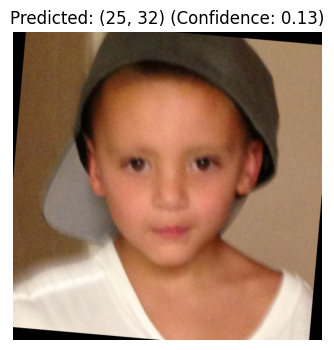

In [19]:
# Load the trained model
model = tf.keras.models.load_model(model_file)
print("Model loaded successfully.")

# Load the LabelEncoder
age_encoder = joblib.load('age_encoder.pkl')
print("Age encoder loaded successfully.")

# Load the scaler
scaler = joblib.load(scaler_file)
print("Feature scaler loaded successfully.")

def predict_age_pca(image_path, model, age_encoder, scaler, n_components=256):
    """
    Predict the age range for a given face image using PCA features.
    
    Parameters:
    image_path (str): Path to the image file
    model: Trained Keras model
    age_encoder: Trained LabelEncoder for age classes
    scaler: Trained StandardScaler for feature normalization
    n_components: Number of PCA components used
    
    Returns:
    tuple: (predicted_age_range, confidence)
    """
    # Check if file exists
    if not os.path.exists(image_path):
        print(f"Error: File {image_path} not found")
        return None, 0
        
    # Extract features using PCA
    print(f"Extracting PCA features from {image_path}...")
    features = rgb2flatPCA([image_path], n_components=n_components)
    
    # Check if feature extraction was successful
    if features.size == 0:
        print("Error: Feature extraction failed")
        return None, 0
        
    # Standardize features
    print("Standardizing features...")
    features_scaled = scaler.transform(features)
    
    # Make prediction
    print("Making prediction...")
    pred_probs = model.predict(features_scaled, verbose=0)[0]
    
    # Get predicted class
    pred_class = np.argmax(pred_probs)
    
    # Convert to age range
    pred_age_range = age_encoder.classes_[pred_class]
    confidence = pred_probs[pred_class]

    return pred_age_range, confidence

# Example usage with a sample image
# Replace with an actual path to test
sample_image_path = test_image_paths[0]  # Using the first test image as an example
print(f"Using sample image: {sample_image_path}")

# Make prediction
pred_age, confidence = predict_age_pca(sample_image_path, model, age_encoder, scaler, n_components)

if pred_age is not None:
    print(f"Predicted age range: {pred_age} with confidence {confidence:.2f}")
    
    # Display the image if possible
    try:
        from PIL import Image
        img = Image.open(sample_image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_age} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")
